In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datasets_dev import load_bbc_news, preprocess_text, extract_relevant_word_vectors
from xboc import XBOCModel, ClusteringMethod, LabelingImplementation, LLMModel
from dotenv import load_dotenv
import numpy as np
import os
from notebooks.utils import load_gensim_w2v

# You need to create a .env file and add the openai api key there like:
# OPENAI_API_KEY=<your-key>
load_dotenv("../")
print(f'Key loaded: {bool(os.environ.get("OPENAI_API_KEY", False))}')

/Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Download complete.
Key loaded: True


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kristiyansakalyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kristiyansakalyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kristiyansakalyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# First steps

- First we need to load the word2vec embeddings. We use a pretrained word2vec model on wikipedia with 100 dimensions.
- Then we need to load the dataset and preprocess it.

In [3]:
wv_model = load_gensim_w2v("../models/enwiki_20180420_100d.txt")
wv_all, idx2word_all = wv_model.vectors, wv_model.index_to_key

In [4]:
# Let's load the dataset and preprocess it.

docs_train, y_train, _, classes = load_bbc_news()
docs_test, y_test, _, _ = load_bbc_news(split="test")
docs_train = [preprocess_text(doc, tokenized=True) for doc in docs_train]  # type: ignore
docs_test = [preprocess_text(doc, tokenized=True) for doc in docs_test]  # type: ignore

/Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/.venv/lib/python3.11/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


In [5]:
# We must extract only the relevant word vectors.
# No need to cluster all of the 4.5 million words

wv_relevant, idx2word_relevant = extract_relevant_word_vectors(
    docs_train, docs_test, idx2word_all, wv_all
)

# Bag of Concept training

### Default parameters

In [7]:
boc_model = XBOCModel(
    docs_train,  # type: ignore
    wv_relevant,  # type: ignore
    idx2word_relevant,  # type: ignore
)
boc_matrix, word2concept_list, idx2word_converter = boc_model.fit()

### Clustering method flexibility

In [8]:
boc_model = XBOCModel(
    docs_train,  # type: ignore
    wv_relevant,  # type: ignore
    idx2word_relevant,  # type: ignore
    clustering_method=ClusteringMethod.KMeans
)
boc_matrix, word2concept_list, idx2word_converter = boc_model.fit()

### Automatic Concept Labeling.

- Labeling using custom or template LLM pipeline.
- Getting the top words associated to each concept.

In [6]:
from xboc.types import Tokenizer

class CustomTokenizer(Tokenizer):
    def __call__(self, text: str) -> list[str]:
        return preprocess_text(text, tokenized=True) # type: ignore

In [34]:
boc_model = XBOCModel(
    docs_train,  # type: ignore
    wv_relevant,  # type: ignore
    idx2word_relevant,  # type: ignore
    tokenizer=CustomTokenizer(), # type: ignore
    n_concepts=20,
    label_impl=LabelingImplementation.TEMPLATE_CHAIN,
    llm_model=LLMModel.OPENAI_GPT3_5
)
boc_matrix, word2concept_list, idx2word_converter = boc_model.fit()

In [8]:
# Let's get the label of concept 0
boc_model.get_concept_label(0)

'Football players'

In [9]:
# Let's see the top words associated to it now.
boc_model.get_top_n_words(10, 0)

['strihavka',
 'hrbaty',
 'lovenkrands',
 'gilhaney',
 'benhabiles',
 'dinked',
 'kickable',
 'kezman',
 'drogba',
 'dugarry']

In [10]:
# Let's see all the concepts
boc_model.get_concept_label()

['Football players',
 'Names',
 'Indie Rock Songs',
 'Food ingredients',
 'Emotions',
 'Italian surnames',
 'Urban landscape',
 'Adjectives',
 'Actions or Events',
 'Technology products and services',
 'Towns',
 'Leadership roles',
 'Connective words',
 'Medical Terminology',
 'Financial Terminology',
 'Negative attitudes',
 'Actions or movements',
 'Telecommunication Companies',
 'Legal proceedings',
 'Last names']

In [7]:
# Now if you have a custom chain you want to use.
# You can define it and provide as:
from xboc.prompts import get_labeling_config

prompt, model = get_labeling_config(LLMModel.OPENAI_GPT3_5)
chain = prompt | model

boc_model = XBOCModel(
    docs_train,  # type: ignore
    wv_relevant,  # type: ignore
    idx2word_relevant,  # type: ignore
    tokenizer=CustomTokenizer(), # type: ignore
    label_impl=LabelingImplementation.CUSTOM_CHAIN,
    custom_chain=chain,
    n_concepts=20,
    verbose=True
)
boc_matrix, word2concept_list, idx2word_converter = boc_model.fit()

[14:13:50] INFO     1. Cluster the word vectors.                                                       ]8;id=192387;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py\model.py]8;;\:]8;id=523096;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py#659\659]8;;\

initialization_time=0.001246 sec, sparsity=0.949
n_iter=1, changed=23624, inertia=12892.808, iter_time=0.707 sec, sparsity=1.0
n_iter=2, changed=9204, inertia=9609.309, iter_time=0.696 sec, sparsity=1.0
n_iter=3, changed=4719, inertia=9262.221, iter_time=0.679 sec, sparsity=1.0
n_iter=4, changed=3110, inertia=9129.092, iter_time=0.694 sec, sparsity=1.0
n_iter=5, changed=2166, inertia=9055.867, iter_time=0.698 sec, sparsity=1.0
n_iter=6, changed=1478, inertia=9021.182, iter_time=0.696 sec, sparsity=1.0
n_iter=7, changed=1146, inertia=9005.414, iter_time=0.680 sec, sparsity=1.0
n_iter=8, changed=899, inertia=8995.250, iter_time=0.696 sec, sparsity=1.0
n_iter=9, changed=776, inertia=8988.133, iter_time=0.696 sec, sparsity=1.0
n_iter=10, changed=686, inertia=8981.989, iter_time=0.691 sec, sparsity=1.0
n_iter=11, changed=642, inertia=8975.743, iter_time=0.684 sec, sparsity=1.0
n_iter=12, changed=584, inertia=8970.280, iter_time=0.695 sec, sparsity=1.0
n_iter=13, changed=552, inertia=8965.41

[14:14:40] INFO     2. Create a bag of words.                                                          ]8;id=69118;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py\model.py]8;;\:]8;id=560726;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py#659\659]8;;\

           INFO     3. Map words to concepts.                                                          ]8;id=831162;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py\model.py]8;;\:]8;id=297250;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py#659\659]8;;\

           INFO     4. Compute the CF-IDF                                                              ]8;id=525452;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py\model.py]8;;\:]8;id=188174;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py#659\659]8;;\

           INFO     5. Automatically label the concepts                                                ]8;id=658047;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py\model.py]8;;\:]8;id=914779;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py#659\659]8;;\

[14:14:41] INFO     Conept label: Football players                                                     ]8;id=632043;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py\model.py]8;;\:]8;id=725531;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py#659\659]8;;\
                    Keywords: strihavka, hrbaty, lovenkrands, gilhaney, benhabiles, dinked, kickable,              
                    kezman, drogba, dugarry                                                                        

[14:15:19] INFO     Conept label: Names                                                                ]8;id=387059;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py\model.py]8;;\:]8;id=472440;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py#659\659]8;;\
                    Keywords: hussain, abdullatif, mohammad, amin, mohammed, ahmed, mansoor, iqbal,                
                    habib, abdul                                                                                   

[14:15:20] INFO     Conept label: Indie Rock Songs                                                     ]8;id=215953;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py\model.py]8;;\:]8;id=714107;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py#659\659]8;;\
                    Keywords: britneys, crazy, playboyz, daze, foreverman, killamangiro, scream,                   
                    jukebox, gotty, kid                                                                            

[14:15:22] INFO     Conept label: Food ingredients                                                     ]8;id=389569;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py\model.py]8;;\:]8;id=414130;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py#659\659]8;;\
                    Keywords: honey, dried, carrot, bean, scragged, flakier, goat, fruit, butter,                  
                    rabbit                                                                                         

           INFO     Conept label: Emotions                                                             ]8;id=624993;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py\model.py]8;;\:]8;id=227711;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py#659\659]8;;\
                    Keywords: believing, terrified, disgusted, telling, pretending, seeing, knowing,               
                    enraged, frightened, horrified                                                                 

[14:15:23] INFO     Conept label: Italian surnames                                                     ]8;id=392680;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py\model.py]8;;\:]8;id=214980;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py#659\659]8;;\
                    Keywords: valbon, gerolami, mikosz, alberto, rossi, roberto, abensur, mauro,                   
                    ancic, claudio                                                                                 

[14:15:24] INFO     Conept label: Urban landscape                                                      ]8;id=338580;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py\model.py]8;;\:]8;id=466977;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py#659\659]8;;\
                    Keywords: corridor, near, nearby, crossing, area, waterfront, downtown,                        
                    overlooking, stretch, ramp                                                                     

[14:15:25] INFO     Conept label: Adjectives                                                           ]8;id=436101;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py\model.py]8;;\:]8;id=739855;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py#659\659]8;;\
                    Keywords: pathetic, amusing, unsettling, quirky, laughable, ridiculous, cynical,               
                    offputting, clever, admittedly                                                                 

           INFO     Conept label: Actions or Events                                                    ]8;id=202679;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py\model.py]8;;\:]8;id=659813;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py#659\659]8;;\
                    Keywords: pushed, brought, overwhelmed, turned, dragged, fell, however, prevented,             
                    thwarted, leaving                                                                              

[14:15:26] INFO     Conept label: Technology products and services                                     ]8;id=556217;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py\model.py]8;;\:]8;id=584392;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py#659\659]8;;\
                    Keywords: tivos, tivotogo, possibilty, hypertag, netmd, thinkvantage, diallers,                
                    software, ipodder, mirapoint                                                                   

[14:15:27] INFO     Conept label: Towns                                                                ]8;id=235876;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py\model.py]8;;\:]8;id=285501;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py#659\659]8;;\
                    Keywords: chorley, bootle, stockport, middleton, coventry, sutton, bolton,                     
                    crawley, morpeth, shrewsbury                                                                   

[14:15:28] INFO     Conept label: Leadership roles                                                     ]8;id=246488;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py\model.py]8;;\:]8;id=460815;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py#659\659]8;;\
                    Keywords: jcwi, adviser, advisor, consultant, chairing, chaired, pitylak,                      
                    thefirst, treasurer, secretary                                                                 

           INFO     Conept label: Connective words                                                     ]8;id=421820;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py\model.py]8;;\:]8;id=876650;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py#659\659]8;;\
                    Keywords: furthermore, therefore, moreover, onstart, contrast, particular,                     
                    example, limiting, use, possible                                                               

[14:15:30] INFO     Conept label: Medical Terminology                                                  ]8;id=563275;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py\model.py]8;;\:]8;id=807908;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py#659\659]8;;\
                    Keywords: desmoteplase, chronic, infection, dysfunction, tissue, symptomatic,                  
                    abnormal, clotting, hypertension, norvasc                                                      

           INFO     Conept label: Financial Terminology                                                ]8;id=922064;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py\model.py]8;;\:]8;id=417555;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py#659\659]8;;\
                    Keywords: payment, unblighted, repayment, underwriting, financing, depreciation,               
                    debt, investment, dividend, refund                                                             

[14:15:31] INFO     Conept label: Negative attitudes                                                   ]8;id=335565;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py\model.py]8;;\:]8;id=577551;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py#659\659]8;;\
                    Keywords: cynicism, trivialises, pessimism, complacency, stressing, irony,                     
                    ignorance, preoccupation, individuality, morality                                              

[14:15:32] INFO     Conept label: Actions or movements                                                 ]8;id=658872;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py\model.py]8;;\:]8;id=824452;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py#659\659]8;;\
                    Keywords: overbalancing, sticking, squeezing, accomodate, pulling, sliding, slung,             
                    nose, stick, ripping                                                                           

           INFO     Conept label: Telecommunication Companies                                          ]8;id=457960;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py\model.py]8;;\:]8;id=636141;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py#659\659]8;;\
                    Keywords: musiwave, easymobile, onetel, broadreach, alcobev, datamonitor, mtfg,                
                    pagesjaunes, ofex, mblox                                                                       

[14:15:33] INFO     Conept label: Legal proceedings                                                    ]8;id=30435;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py\model.py]8;;\:]8;id=702043;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py#659\659]8;;\
                    Keywords: objecting, denying, arguing, discriminatorily, legality, prosecution,                
                    declaring, ramrodded, alleged, justified                                                       

[14:15:34] INFO     Conept label: Last names                                                           ]8;id=879971;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py\model.py]8;;\:]8;id=825042;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py#659\659]8;;\
                    Keywords: bennett, miller, dunn, harris, taylor, baker, mitchell, lawson, smith,               
                    moore                                                                                          

In [11]:
boc_model.get_concept_label()

['Football players',
 'Names',
 'Indie Rock Songs',
 'Food ingredients',
 'Emotions',
 'Italian surnames',
 'Urban landscape',
 'Adjectives',
 'Actions or Events',
 'Technology products and services',
 'Towns',
 'Leadership roles',
 'Connective words',
 'Medical Terminology',
 'Financial Terminology',
 'Negative attitudes',
 'Actions or movements',
 'Telecommunication Companies',
 'Legal proceedings',
 'Last names']

### Save and Load model

In [14]:
boc_model.save("../models")

[14:27:23] INFO     Successfully saved the model at: ../models/BoC_c20.pickle                          ]8;id=656312;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py\model.py]8;;\:]8;id=973745;file:///Users/kristiyansakalyan/Documents/uni/nlp-lab/bertopic-document-representations/boc/model.py#665\665]8;;\

In [15]:
boc_model = XBOCModel.load("../models/BoC_c20.pickle")

In [13]:
boc_model.concept_labels

['Emotions',
 'Transportation vehicles',
 'Football players',
 'Company names',
 'Technology/software terms',
 'Existentialism',
 'Law enforcement actions',
 'Actions with objects',
 'Music genres',
 'Professions',
 'Adjectives',
 'Names',
 'English vocabulary',
 'Location or vicinity',
 'Horror',
 'Last names',
 'Medical conditions',
 'Names',
 'Language connectors',
 'Towns']

### Encode new documents.

In [18]:
boc_model.word2idx

{'megane': 0,
 'reserved': 1,
 'illustration': 2,
 'stunned': 3,
 'unfreeze': 4,
 'theme': 5,
 'awol': 6,
 'kleinberg': 7,
 'trebled': 8,
 'flight': 9,
 'black': 10,
 'upscale': 11,
 'rebidding': 12,
 'satisfactorily': 13,
 'velimir': 14,
 'verify': 15,
 'sender': 16,
 'dealership': 17,
 'thinker': 18,
 'santry': 19,
 'aurora': 20,
 'retrospective': 21,
 'oleg': 22,
 'communication': 23,
 'slotting': 24,
 'nasa': 25,
 'horde': 26,
 'buscemi': 27,
 'prompt': 28,
 'permanently': 29,
 'tape': 30,
 'gomarsall': 31,
 'migrant': 32,
 'dutronc': 33,
 'jrfu': 34,
 'withstand': 35,
 'zone': 36,
 'kilgore': 37,
 'forestier': 38,
 'contreras': 39,
 'dispossesed': 40,
 'scabbers': 41,
 'pompous': 42,
 'verbal': 43,
 'colonel': 44,
 'irreversible': 45,
 'preliminary': 46,
 'witness': 47,
 'jeroen': 48,
 'tina': 49,
 'rendition': 50,
 'healey': 51,
 'venturas': 52,
 'janus': 53,
 'hereditary': 54,
 'rebirth': 55,
 'diet': 56,
 'olof': 57,
 'splash': 58,
 'segas': 59,
 'profited': 60,
 'cute': 61,
 '

In [17]:
document = "Hello. This document great football players and sports."
boc_model.encode(document).toarray() # type: ignore

array([[0.33382097, 0.        , 0.02898754, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.05107849, 0.        , 0.        , 0.08515781, 0.        ]])

In [18]:
boc_model.get_concept_label(2)

'Indie Rock Songs'

### Shap values

In [19]:
X_train = np.array(boc_matrix.toarray())
y_train = np.array(y_train)

X_test = [boc_model.encode(doc).toarray() for doc in docs_test]
X_test = np.array(X_test).squeeze(1)
y_test = np.array(y_test)
# We already have y_train and y_test

In [20]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1225, 20), (1225,), (1000, 20), (1000,))

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return precision, recall, f1

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
precision, recall, f1 = calculate_metrics(y_test, y_pred)
print("Logistic Regression\n\tAccuracy:", accuracy_score(y_test, y_pred), "\n\tPrecision:", precision, "\n\tRecall:", recall, "\n\tF1 Score:", f1)

# Random Forest
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
precision, recall, f1 = calculate_metrics(y_test, y_pred)
print("Random Forest\n\tAccuracy:", accuracy_score(y_test, y_pred), "\n\tPrecision:", precision, "\n\tRecall:", recall, "\n\tF1 Score:", f1)

Logistic Regression
	Accuracy: 0.92 
	Precision: 0.9194124964764308 
	Recall: 0.9175068196085145 
	F1 Score: 0.9179880828062812
Random Forest
	Accuracy: 0.951 
	Precision: 0.9509260223253836 
	Recall: 0.9501784919412037 
	F1 Score: 0.9503910393189342


In [22]:
import shap

### Explain Logistic Regression

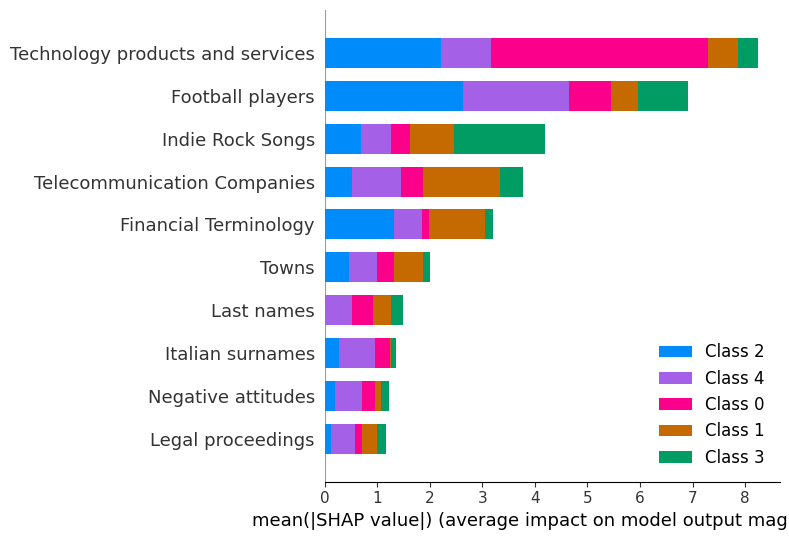

In [23]:
explainer = shap.LinearExplainer(log_reg, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=boc_model.get_concept_label(), max_display=10)

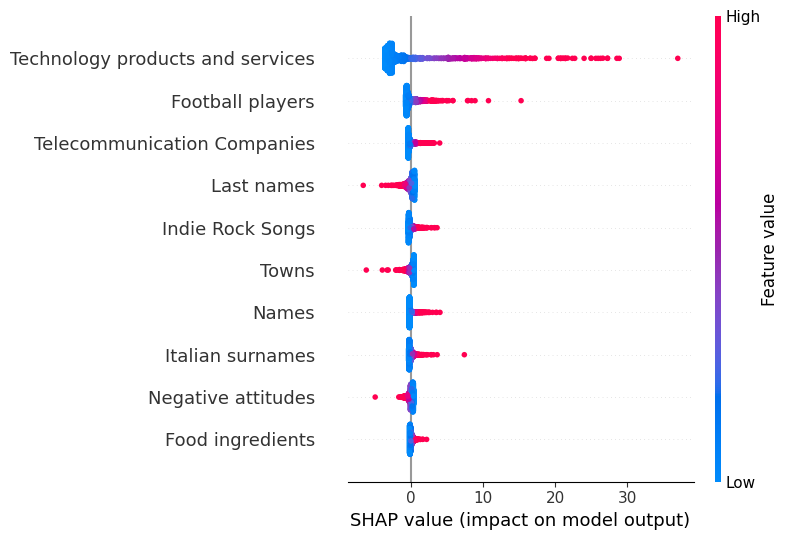

In [24]:
shap.summary_plot(shap_values[0], X_test, feature_names=boc_model.get_concept_label(), max_display=10)

### Explain Random Forest classifier

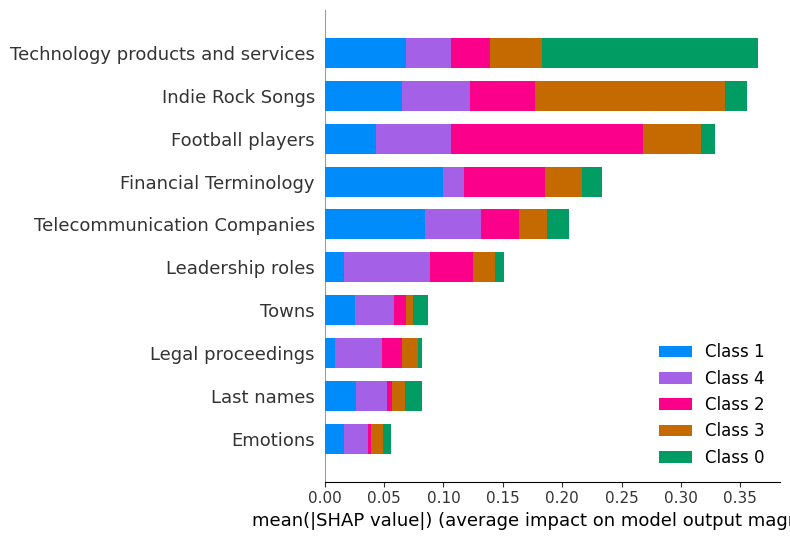

In [25]:
explainer = shap.TreeExplainer(random_forest)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=boc_model.get_concept_label(), max_display=10)

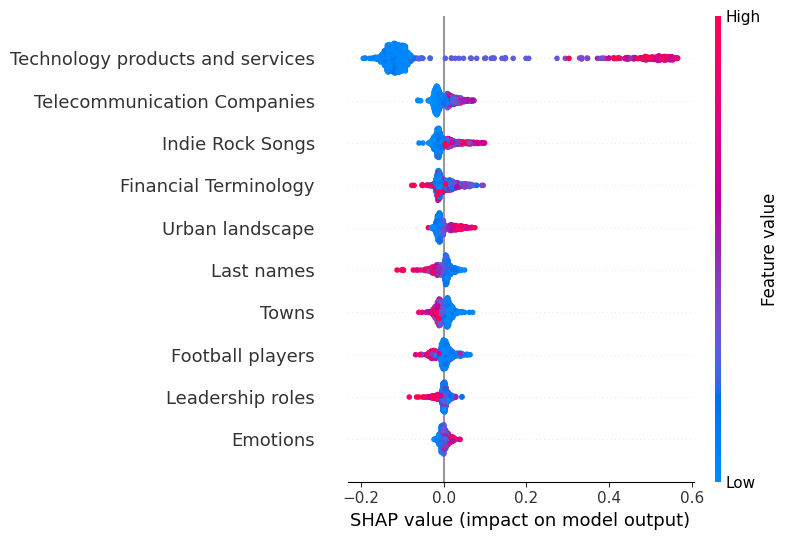

In [26]:
shap.summary_plot(shap_values[0], X_test, feature_names=boc_model.get_concept_label(), max_display=10)